# GP surrogate model

This notebook creates a surrogate model of EPANET's water quality solver using Gaussian Process (GP) regression.

In [107]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
import scipy.stats as stats
from scipy.stats import norm, truncnorm
import random
from pyDOE import lhs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C
from bayesian_wq_calibration.epanet import build_model, sensor_model_id, epanet_simulator, set_reaction_parameters
from bayesian_wq_calibration.mcmc import decision_variables_to_dict
from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
from bayesian_wq_calibration.data import bulk_temp_adjust

### Load data

Load operational data for selected sensing period.

In [108]:
data_period = 19 # 21 calibration events (as at 31 October 2024)
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
except:
    print(f"Data period {data_period} does not exist.")

Surrogate model data period.

In [109]:
surrogate_days = 2

n_total = len(flow_df['datetime'].unique())
n_surrogate = surrogate_days * 24 * 4
surrogate_range = range(n_surrogate)
surrogate_datetime = flow_df['datetime'].unique()[list(surrogate_range)]
total_range = range(n_total)
total_datetime = flow_df['datetime'].unique()[list(total_range)]

Bulk decay.

In [110]:
bulk_coeff = -0.85 # day^-1 (from bottle tests)
field_temp = wq_df[wq_df['data_type'] == 'temperature']['mean'].mean()
bulk_coeff = bulk_temp_adjust(bulk_coeff, field_temp)

Wall decay grouping.

In [111]:
grouping = 'material-velocity' # 'single', 'material', 'material-diameter', 'material-velocity'

if grouping == 'single':
    param_bounds = [(-0.5, 0.0)]
    param_mean = []
    
elif grouping == 'material':
    # variable order: metallic, cement, plastic_unknown
    param_bounds = [(-0.5, 0.0), (-0.1, 0.0), (-0.05, 0.0)]
    param_mean = []
    
elif grouping == 'material-diameter':
    # variable order: metallic_less_than_150, metallic_greater_than_150, cement, plastic_unknown
    param_bounds = [(-0.5, 0.0), (-0.25, 0.0), (-0.1, 0.0), (-0.05, 0.0)]
    param_mean = []
    
elif grouping == 'material-velocity':
    # variable order: metallic_low_velocity, metallic_high_velocity, cement_low_velocity, cement_high_velocity, plastic_low_velocity, plastic_high_velocity
    param_bounds = [(-0.5, 0.0), (-0.25, 0.0), (-0.5, 0.0), (-0.25, 0.0), (-0.01, 0.0), (-0.005, 0.0)] 
    param_mean = [-0.135, -0.056, -0.074, -0.150, -0.010, -0.002]
    
wall_params = [random.uniform(lower, upper) for lower, upper in param_bounds]
n_params = len(wall_params)

### Surrogate model

**EPANET simulator**

Build water model using `wntr`.

In [112]:
demand_resolution = 'wwmd'
wn = build_model(flow_df[flow_df['datetime'].isin(surrogate_datetime)], pressure_df[pressure_df['datetime'].isin(surrogate_datetime)], cl_df[cl_df['datetime'].isin(surrogate_datetime)], sim_type='chlorine', demand_resolution=demand_resolution, bulk_coeff=bulk_coeff)

Get mean velocities (for 'material-velocity' grouping).

In [113]:
if grouping == 'material-velocity':
    sim_results = epanet_simulator(wn, 'velocity', cl_df[cl_df['datetime'].isin(surrogate_datetime)])
    vel_sim = sim_results.velocity.T
    mean_vel = vel_sim.mean(axis=1)
    mean_vel = mean_vel.reset_index().rename(columns={'name': 'link_id', 0: 'mean_vel'})
else:
    mean_vel = None

Define simualtor function.

In [114]:
def simulator(cl_df, wall_params, wn, grouping, mean_vel):
    wall_params = decision_variables_to_dict(grouping, wall_params)
    _wn = set_reaction_parameters(wn, grouping, wall_params, None, mean_vel)
    
    sim_type = 'chlorine'
    sim_results = epanet_simulator(_wn, sim_type, cl_df)
    cl_sim = sim_results.chlorine
    
    sensor_data = sensor_model_id('wq')
    cl_sim = cl_sim[sensor_data['model_id'].unique()]
    name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
    cl_sim = cl_sim.rename(columns=name_mapping)

    cl_sim = cl_sim.T
    cl_sim.columns = [f't_{idx+1}' for idx in range(cl_sim.shape[1])]

    cl_sim = cl_sim.drop(index=['BW1', 'BW4'], errors='ignore') # remove inlet sensors
    
    return cl_sim

In [115]:
cl_simulator = simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], wall_params, wn, grouping, mean_vel)
sensor_names = cl_simulator.index.to_numpy()

**Design of experiments**

Latin Hypercube Sampling (LHS).

In [116]:
def generate_lhs_samples(param_mean, n_samples, relative_uncertainty=0.1):
    std_values = np.abs(np.array(param_mean) * relative_uncertainty)
    param_distributions = list(zip(param_mean, std_values))
    
    n_params = len(param_distributions)
    samples = lhs(n_params, samples=n_samples)
    
    scaled_samples = np.array([
        truncnorm.ppf(
            sample, 
            a=(float('-inf') - mu) / sigma,
            b=(0 - mu) / sigma, 
            loc=mu, 
            scale=sigma
        )
        for (mu, sigma), sample in zip(param_distributions, samples.T)
    ]).T

    return scaled_samples

In [119]:
n_samples = [10, 25, 50, 100, 200]
n_samples_idx = 3

X = generate_lhs_samples(param_mean, n_samples[n_samples_idx], relative_uncertainty=0.75)
Y = np.array([
    simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], params, wn, grouping, mean_vel)
    for params in X
])

**Gausian process model training**

Training procedure using five-fold cross-validation and `scikit-learn` modules. The following kernel's can be used:
- Radial basis function (RBF)
- Matern
- Rational quadratic

Note: a separate GP is trained for each of the **7** sensors.

In [120]:
sensor = 'BW2' # 'BW2', 'BW3', 'BW5', 'BW6', 'BW7', 'BW9', 'BW12'
s = np.where(sensor_names == sensor)[0][0]
Y_s = Y[:, s, :].reshape(Y.shape[0], Y.shape[2])

In [121]:
# train/validate and test datasets
n_0 = round(0.8*len(X))
X_0 = X[:n_0, :]
Y_s_0 = Y_s[:n_0, :]

In [122]:
# scikit-learn model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C

def GPRegressor(kernel_type='RBF', nu=1.5, n_restarts=50, normalize_y=True):

    if kernel_type == 'RBF':
        kernel = C(1.0, (1e-1, 1e5)) * RBF(1.0, (1e-1, 1e10))
    elif kernel_type == 'Matern':
        kernel = C(1.0, (1e-1, 1e5)) * Matern(1.0, (1e-1, 1e10), 0.5)
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts, normalize_y=normalize_y)
    
    return gp

Cross-validation.

In [123]:
# setup parameters
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
kernel = 'RBF' # 'RBF', 'Matern'
gp = GPRegressor(kernel_type=kernel, nu=0.5, n_restarts=50, normalize_y=True)

# cross-validation loop
hyperparameter_performance = []
for fold, (train_idx, validate_idx) in enumerate(kf.split(X_0)):

    X_train, X_validate = X_0[train_idx], X_0[validate_idx]
    Y_train, Y_validate = Y_s_0[train_idx], Y_s_0[validate_idx]

    gp.fit(X_train, Y_train)
    Y_pred = gp.predict(X_validate)

    rmse = np.sqrt(mean_squared_error(Y_validate, Y_pred))
    mae = mean_absolute_error(Y_validate, Y_pred)
    maxae = np.max(np.abs(Y_validate - Y_pred))
    hyperparameter_performance.append({
        "fold": fold + 1,
        "rmse": rmse,
        "mae": mae,
        "maxae": maxae,
        "length_scale": gp.kernel_.get_params()['k2__length_scale'],
        "variance": gp.kernel_.get_params()['k1__constant_value']
    })

    print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MaxAE: {maxae:.4f}")

Fold 1 - RMSE: 0.0008, MAE: 0.0003, MaxAE: 0.0122
Fold 2 - RMSE: 0.0013, MAE: 0.0004, MaxAE: 0.0236
Fold 3 - RMSE: 0.0017, MAE: 0.0004, MaxAE: 0.0416
Fold 4 - RMSE: 0.0021, MAE: 0.0007, MaxAE: 0.0448
Fold 5 - RMSE: 0.0006, MAE: 0.0002, MaxAE: 0.0116


Re-train GP model with entire dataset.

In [124]:
gp.fit(X_0, Y_s_0)
print(gp.kernel_.get_params())

{'k1': 4.83**2, 'k2': RBF(length_scale=0.311), 'k1__constant_value': 23.2850571002227, 'k1__constant_value_bounds': (0.1, 100000.0), 'k2__length_scale': 0.3108633503095373, 'k2__length_scale_bounds': (0.1, 10000000000.0)}


Test model performance.

In [129]:
X_1 = X[n_0:]
Y_s_1 = Y_s[n_0:, :]
Y_pred, sigma = gp.predict(X_1, return_std=True)
Y_upper = Y_pred + 1.96 * sigma
Y_lower = Y_pred - 1.96 * sigma

Test results plotting.

Root mean squared error: 0.0017546721814021167
Mean absolute error: 0.0004419602112950713
Maximum absolute error: 0.03665693290848454
Kernel: RBF, r^2 Score: -8.618730160396451


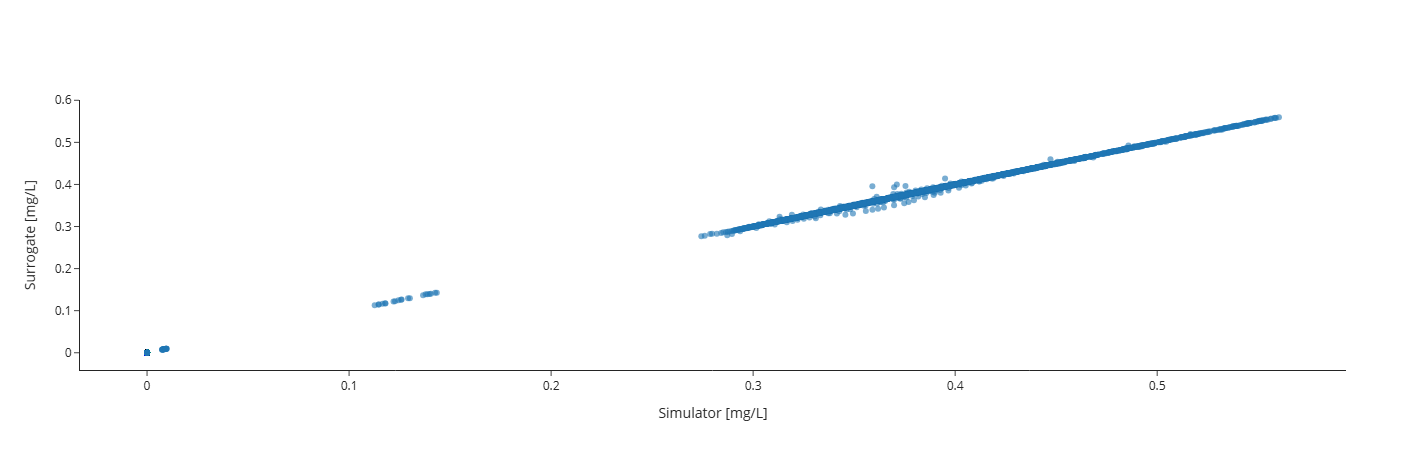

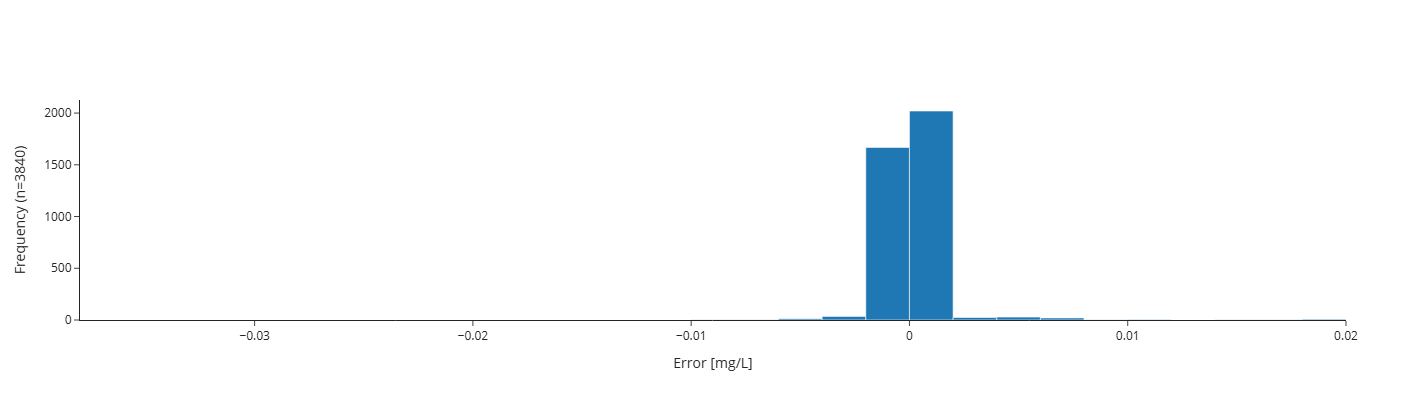

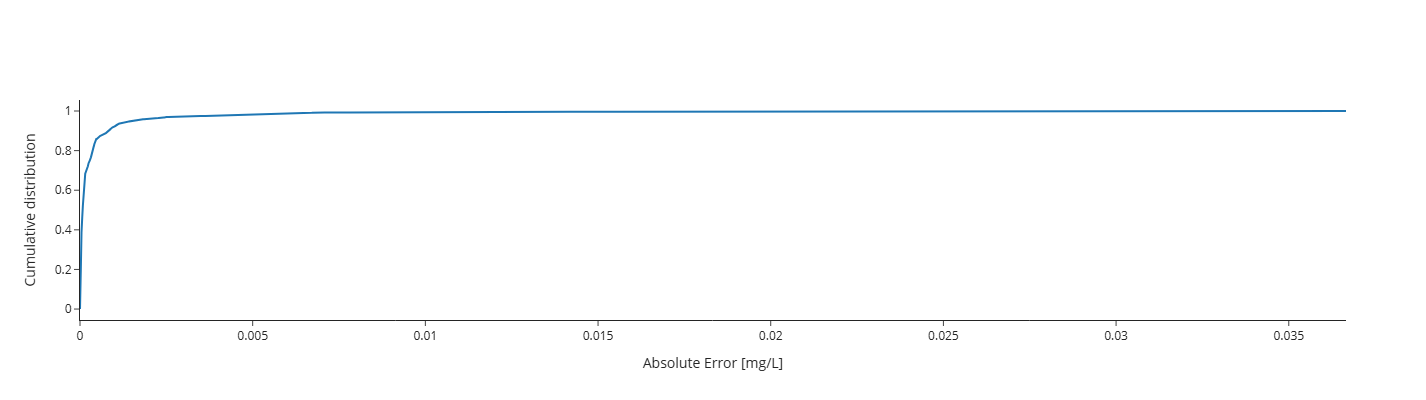

In [130]:
# performance metrics
rmse = np.sqrt(np.mean((Y_s_1 - Y_pred) ** 2))
print(f"Root mean squared error: {rmse}")
mae = np.mean(np.abs(Y_s_1 - Y_pred))
print(f"Mean absolute error: {mae}")
maxae = np.max(np.abs(Y_s_1 - Y_pred))
print(f"Maximum absolute error: {maxae}")
r2 = gp.score(X_test, Y_s_1)
print(f"Kernel: {kernel}, r^2 Score: {r2}")

# parity plot of surrogate v. simulator
fig = go.Figure(data=go.Scatter(
    x=Y_s_1.flatten(),
    y=Y_pred.flatten(),
    mode='markers',
    marker=dict(size=6, opacity=0.6),
))
fig.update_layout(
    xaxis_title="Simulator [mg/L]",
    yaxis_title="Surrogate [mg/L]",
    template="simple_white",
    width=550,
    height=450
)
fig.show()

# histogram plot of errors
errors = (Y_s_1 - Y_pred).flatten()
fig = go.Figure(data=[go.Histogram(x=errors, nbinsx=40)])
fig.update_layout(
    xaxis_title="Error [mg/L]",
    yaxis_title=f"Frequency (n={len(errors)})",
    template="simple_white",
    width=600,
    height=400
)
fig.show()

# cdf plot of absolute errors
absolute_errors = np.abs(Y_s_1 - Y_pred).flatten()
sorted_errors = np.sort(absolute_errors)
cdf_values = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sorted_errors,
    y=cdf_values,
    mode='lines',
))
fig.update_layout(
    xaxis_title="Absolute Error [mg/L]",
    yaxis_title="Cumulative distribution",
    template="simple_white",
    width=600,
    height=400
)
fig.show()

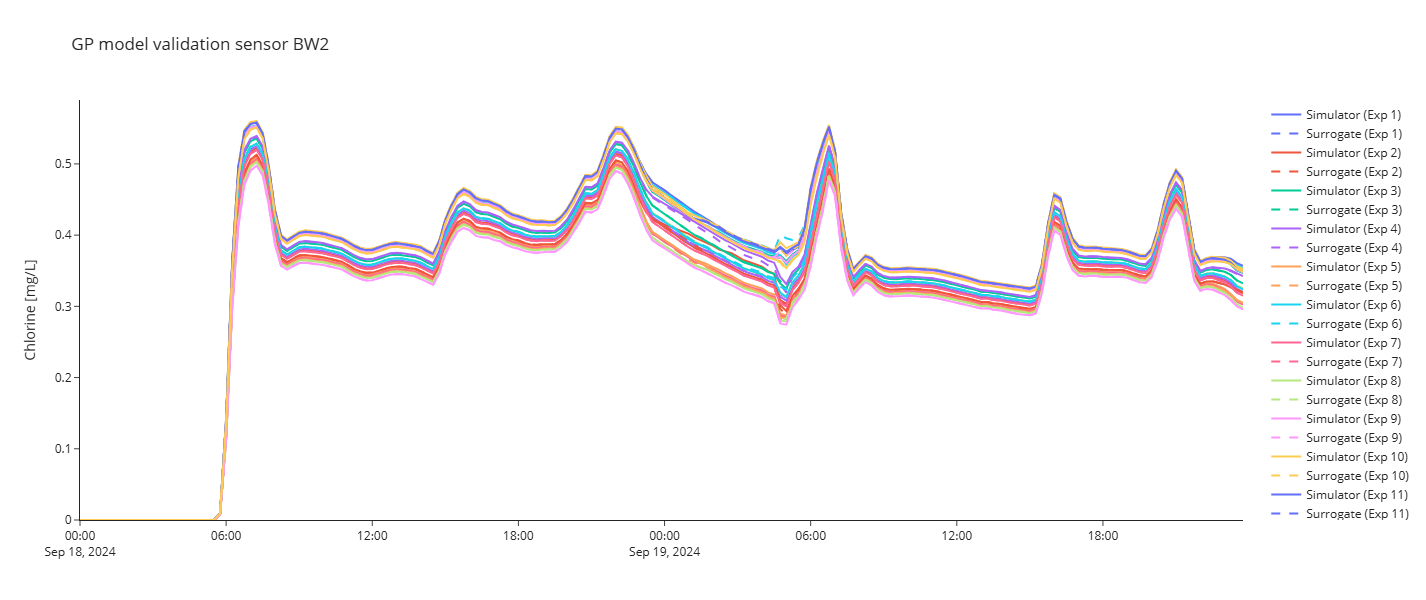

In [132]:
fig = go.Figure()

actual_data = Y_s_1
predicted_data = Y_pred

for exp_idx in range(n_test):
    color = default_colors[exp_idx % len(default_colors)]
    fig.add_trace(
        go.Scatter(
            x=surrogate_datetime,
            y=actual_data[exp_idx, :],
            mode='lines',
            name=f"Simulator (Exp {exp_idx + 1})",
            line=dict(color=color, dash='solid'),
            showlegend=True
        )
    )
    fig.add_trace(
        go.Scatter(
            x=surrogate_datetime,
            y=predicted_data[exp_idx, :],
            mode='lines',
            name=f"Surrogate (Exp {exp_idx + 1})",
            line=dict(color=color, dash='dash'),
            showlegend=True
        )
    )
fig.update_yaxes(
    title_text="Chlorine [mg/L]",
    rangemode="tozero"
)
fig.update_layout(
    height=600,  # Fixed height since there's only one plot
    template='simple_white',
    legend_title_text='',
    title=f"GP model validation sensor {sensor}"
)
fig.show()